In [2]:
import sys
import numpy as np
import catmap


from catmap import ReactionModel
from catmap import analyze
from catmap.parsers import TableParser

In [2]:
mechanism = '''
                'N2_g + * -> N2*', #1
                
                'N2* + H* -> N2H* + *', #2
                
                'N2H* + H* -> N2H2* + *', #3
                
                'N2H2* + H* -> H2NNH* + *', #4 
                
                'H2NNH* + H* -> H2NNH2* + *', #5
                
                'H2NNH2* + H* -> NH2* + NH3*', #6
                
                'NH2* + NH3* + H* -> 2NH3*  + *', #7
                
                '2NH3*  -> 2NH3_g + 2*', #8
                
                'H2_g + 2* -> 2H*',
                'N2_g -> N2_g', 
                'H2O_g -> H2O_g',
                'O2_g + * -> O2*',
                'O2_g -> O2_g',
                
'''

In [3]:
content = '''
surface_names = ['slab']
descriptor_names = ['surface']
temperature = 300
species_definitions = {}
species_definitions['N2_g'] = {'pressure':0.8} #define the gas pressures
species_definitions['O2_g'] = {'pressure':1}
species_definitions['NH3_g'] = {'pressure':1}
species_definitions['H2O_g'] = {'pressure':1}
species_definitions['H2_g'] = {'pressure':1}
species_definitions['s'] = {'site_names': ['152'], 'total':1} #define the sites
input_file = 'HSE_catmap_model.txt'
gas_thermo_mode = "ideal_gas"
#gas_thermo_mode = "frozen_fixed_entropy_gas"

adsorbate_thermo_mode = "harmonic_adsorbate"
#adsorbate_thermo_mode = "frozen_adsorbate"

scaler = 'LookupScaler'

rxn_expressions = [%(mech)s]

rxn_mechanisms = {  "s": [1,2,3,4,5,6,7,8,9]} 

'''%{'mech': mechanism}

with open('HSE_NRR_rxn.mkm', 'w') as f:
    f.write(content)
ls = ['slab']
mkm_file = 'HSE_NRR_rxn.mkm'
model = ReactionModel(setup_file=mkm_file)
ma = analyze.MechanismAnalysis(model)

ma.energy_type = 'free_energy' #can also be free_energy/potential_energy
# ma.energy_type = 'potential_energy'

# ma.energy_mode = 'absolute'
ma.energy_mode = 'relative'

ma.pressure_correction = False #assume all pressures are 1 bar (so that energies are the same as from DFT)
ma.include_labels = True

fig = ma.plot(plot_variants = ls)



Info: set resolution to 15 as default.


### Import Free Energy from CATMAP

In [4]:
free_energy_dictionay = model.scaler.get_free_energies('slab').copy()
free_energy_dictionay
free_energy_dictionay['H_g'] = 0.5* free_energy_dictionay['H2_g']
free_energy_dictionay

import pickle
# open a file, where you ant to store the data
file = open('SI/HSE_free_energy.pkl', 'wb')
# dump information to that file
pickle.dump(free_energy_dictionay, file)
# close the file
file.close()

### Aligh Reactions

In [6]:
### find reactants and products
from ase.symbols import string2symbols
def balanced(chem_list):
    clean_outer_list=[]
    for l in chem_list:
        clean_list = []
        for a in l:
            chem = a.split('_')[0]
            clean_list.append(chem)
        clean_outer_list.append(clean_list)
    element_balance = dict()
    for ads in clean_outer_list[0]:
        composition = string2symbols(ads)
        for i in composition:
            if i not in element_balance:
                element_balance[i] = 1
            else:
                element_balance[i] += 1
    for n, step in enumerate(clean_outer_list):
        counter = dict()
        for ads in step:
            composition = string2symbols(ads)
            for i in composition:
                if i not in counter:
                    counter[i] = 1
                else:
                    counter[i] += 1
        if counter != element_balance:
    return True
            
def count_element(rxn):
    mech_step = dict()
    total_count = set()
    for i,r in enumerate(rxn):
        reactants=r.split('->')[0].strip()
        reactants = reactants.split('+')
        mech_step[i] = dict()
        mech_step[i]['reactant'] = []
        mech_step[i]['product'] = []
        for rea in reactants:
            rea = rea.strip(' ')
            mech_step[i]['reactant'].append(rea)
            total_count.add(rea)
        try:
            products = r.split('->')[1].strip()
        except:
            continue
        products = products.split('+')
        for pro in products:
            pro = pro.strip(' ')
            mech_step[i]['product'].append(pro)
            total_count.add(pro)
    return total_count,mech_step

def get_rxn_network(rxn):
    total_count, mech_step=count_element(rxn)
    ingredient_list = {}
    for (i, ingredient) in enumerate(total_count):
        ingredient_list[ingredient] = i
    rxn_network = np.zeros((len(rxn),len(ingredient_list)))
    for i in range(len(rxn)):
        for reactant in mech_step[i]['reactant']:
            j = ingredient_list[reactant]
            rxn_network[i,j] -= 1
        for product in mech_step[i]['product']:
            j = ingredient_list[product]
            rxn_network[i,j] += 1
    return rxn_network,ingredient_list
            
def create_mass_balance(rxn):
    rxn_network, ingredient = get_rxn_network(rxn)
    result =[]
    for l in range(len(rxn_network)):
        tot_reactant = []
        tot_product = []
        coeff = rxn_network[l:].sum(axis=0)
        for i,c in zip(ingredient, coeff):
            if -c >0:
                c=int(-c)
                tot_reactant.extend(c*[i])
        for i,c in zip(ingredient, rxn_network[:l].sum(axis=0)):
            if c>0:
                c=int(c)
                tot_product.extend(c*[i])
        for i,p in enumerate(tot_product):
            if tot_product.count(p) >= tot_reactant.count(p):
                d = tot_product.count(p)- tot_reactant.count(p)
                tot_reactant.extend(d*[p])
        result.append(tot_reactant)
    if not balanced(result):
        print('Not balanced.')
    return result


In [7]:
################# REACTIONS #################
NRR_rxn = [ 'N2_g -> N2_s',
            'N2_s + H_g -> N2H_s ',
            'N2H_s + H_g -> N2H2_s',
            'N2H2_s + H_g -> H2NNH_s',
            'H2NNH_s + H_g -> H2NNH2_s ',
            'H2NNH2_s + H_g -> NH2_s  + NH3_s', 
            'NH2_s + NH3_s + H_g -> NH3_s + NH3_s',
            'NH3_s + NH3_s -> NH3_g + NH3_g',
             'NH3_g + NH3_g']

NRR_chem_list = [
             ['N2_g'],
             ['N2_s'],
             ['N2H_s'],
             ['N2H2_s'],
             ['H2NNH_s'],
             ['H2NNH2_s'],
             ['NH2_s','NH3_s'],
             ['2NH3_s'],
             ['2NH3_g'],]
         

### Obtain free energy level according to reaction

In [8]:
def get_E_list(chem_list,free_energy_dictionay):
    E_list = []
    for rxn in chem_list:
        rxn_eng = []
        for c in rxn:
            rxn_eng.append(free_energy_dictionay[c])
        E_list.append(sum(rxn_eng))
    return E_list

def collapse_label_list(chem_list):
    new_list = []
    for rxn in chem_list:
        new_rxn = []
        for name in rxn:
            for kj in range(0,9):
                name = name.replace(str(kj), '$_{'+str(kj)+'}$')
            name = name.replace('_s', '*')
            name = name.replace('_g', '(g)')
            new_rxn.append(name)
        s = ' + '.join(new_rxn)
        new_list.append(s)
    return new_list


In [9]:
NRR_rxn_mb = create_mass_balance(NRR_rxn)
labels_NRR=collapse_label_list(NRR_chem_list)
free_energy_NRR_mb = get_E_list(NRR_rxn_mb,free_energy_dictionay)
free_energy_NRR_mb = np.array(free_energy_NRR_mb)

init_g_E = free_energy_NRR_mb[0]
free_energy_NRR_mb-= init_g_E


### Helper functions for plotting

In [35]:
import os
import pickle
import numpy as np
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl


def make_energy_lines(free_energy, color):
    energy_list = np.array(free_energy)
    energy_line_widths = [0.6]*len(free_energy)
    energy_lines = [
            [[i,i+width],[energy_list[i]]*2]
            for i,width in enumerate(energy_line_widths)]
    return energy_lines

def make_barrier_lines(free_energy, energy_lines, color):
    barrier_lines = []
    barriers = [0]*(len(free_energy)-1)
    for i,barrier in enumerate(barriers):
        xi = energy_lines[i][0][1]
        xf = energy_lines[i+1][0][0]
        yi = energy_lines[i][1][0]
        yf = energy_lines[i+1][1][0]
        line = [[xi,xf],[yi,yf]]
        xts = (xi+xf)/2.
        yts = max([yi,yf])
        barrier_lines.append(line)
    return barrier_lines

def change_index(l, diff):
    for i in range(len(l)):
        l[i][0] = list(map(lambda x: x + diff, l[i][0]))
    return l


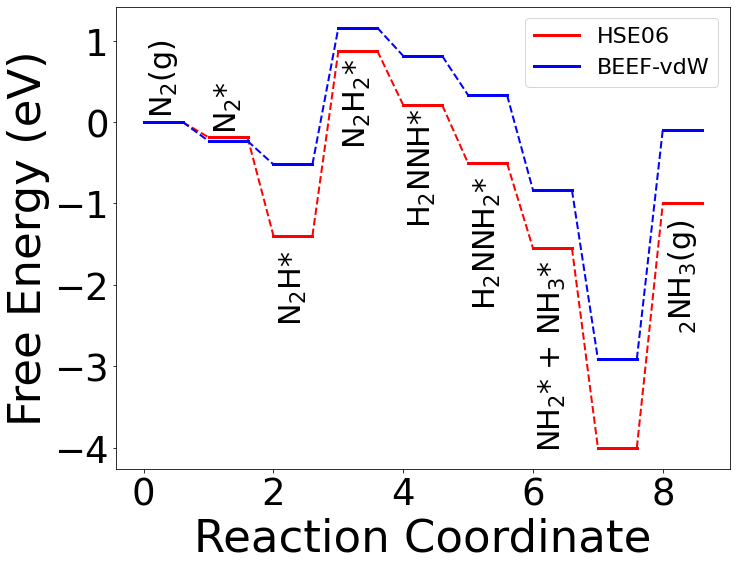

In [45]:
def plot_fed(labels_list, free_energy_list, ensemble_list, color_list, legend_list,ylabel,file_name,redox_label,legend_loc,legend_size):
    mpl.rcParams['text.color'] = 'k'
    fig = plt.figure(figsize = [11,8.5])
    ax = fig.add_subplot(111)
    xy_label_size = 45
    ax.set_xlabel('Reaction Coordinate',fontsize=xy_label_size)
    ax.set_ylabel(ylabel,fontsize=xy_label_size)
    if redox_label:
        ax.plot(0, 0, color='b',linestyle='--',label='Oxidation Step') # Dummy plot to lable
        ax.plot(0, 0, color='r',linestyle='--',label='Reduction Step')
    max_len = max(map(len, free_energy_list))
    for i, free_energy in enumerate(free_energy_list):
        labels = labels_list[i]
        color = color_list[i]
        legend_name = legend_list[i]
        energy_line_args= [{'color': color, 'lw': 3}]
        energy_line_args*=len(labels) 

        barrier_line_args= [{'color': color, 'lw': 2,'linestyle':'dashed'}]
        barrier_line_args*=len(labels) -1

        energy_lines = make_energy_lines(free_energy, color)
        barrier_lines = make_barrier_lines(free_energy,energy_lines, color)
        
        # different number of steps in mechanisms 
        if len(free_energy) < max_len:
            diff_len = max_len - len(free_energy)
            energy_lines = change_index(energy_lines, diff_len)
            barrier_lines = change_index(barrier_lines, diff_len)
        
        label_added = False
        for i,line in enumerate(energy_lines):
            uplims=0.1
            lolims=-0.1
            if not label_added:
                ax.plot(*line,**energy_line_args[i],label = legend_name)#+' pathway')
                label_added = True
            else:
                ax.plot(*line,**energy_line_args[i])
        for i,line in enumerate(barrier_lines):
            if redox_label:
                if legend_name =='MeOH' and i in {11}:
                    ax.plot(*line, color='grey', lw=2,linestyle='dashed')
                elif legend_name =='CH3' and  4<=i<=11:
                    ax.plot(*line, color='r', lw=2,linestyle='dashed')
                else:
                    ax.plot(*line,color='k',**barrier_line_args[i])
            else:
                ax.plot(*line,**barrier_line_args[i],)
        trans = ax.get_xaxis_transform()
        plt.xticks(fontsize= 37)
        plt.yticks(fontsize= 37)
        label_positions=['top'] * len(labels)

        label_args= [{'color': 'k', 'fontsize': 30,
                      'weight':'regular',
                      'ha':'center','rotation':'vertical',
                     'va':'bottom'}]
        label_args*=len(labels)
        if legend_name == 'HSE06':
            for i,label in enumerate(labels):
                xpos = sum(energy_lines[i][0])/len(energy_lines[i][0])
                label_position = label_positions[i]
                args = label_args[i]
                ypos = energy_lines[i][1][0] + 0.05
                if i == 2:
                    ypos = energy_lines[i][1][0] - 1.1
                if i == 3:
                    ypos = energy_lines[i][1][0] - 1.2
                if i == 4:
                    ypos = energy_lines[i][1][0] - 1.5
                if i == 5:
                    ypos = energy_lines[i][1][0] - 1.8
                if i == 6:
                    ypos = energy_lines[i][1][0] - 2.5
                if i == 7:
                    ypos = energy_lines[i][1][0] - 1.8
                if i == 8:
                    ypos = energy_lines[i][1][0] - 1.6
                ax.annotate(label,[xpos,ypos],**args)
    ax.legend(fontsize=legend_size,)
    fig.savefig(file_name,bbox_inches='tight')
    
free_energy_NRR_BEEF_mb = np.array([ 0.        , -0.23279371, -0.52081904,  1.15867494,  0.81187744, 0.33000534, -0.83850211, -2.91193897, -0.09361777])
plot_fed([labels_NRR,labels_NRR], [free_energy_NRR_mb,free_energy_NRR_BEEF_mb], [],color_list = ['r','b'], legend_list=['HSE06','BEEF-vdW'],ylabel = 'Free Energy (eV)',file_name='SI/FED/full_fig_combined.png',redox_label=False,legend_loc=(0.43,0.64),legend_size=22.3)




